<a href="https://colab.research.google.com/github/c240030/Project-Veritas/blob/tam/model_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# Setup
from pathlib import Path
import os
from google.colab import userdata
# Project paths
DATA_RAW = Path("data/raw")
DATA_PROCESSED = Path("data/processed")
RAW_CSV = DATA_RAW / "ucsd_delaware_reviews_combined.csv"   # adjust if needed
FEAT_CSV = DATA_PROCESSED / "reviews_with_features.csv"
RULE_CSV = DATA_PROCESSED / "predictions_rule_based.csv"
LLM_OUT  = DATA_PROCESSED / "predictions_llm.csv"
LR_OUT   = DATA_PROCESSED / "predictions_fallback_lr.csv"

# Settings
TEXT_COL = "text"          # adjust if your CSV column is named differently
USER_COL = "user_id"
SAMPLE_SIZE = 58290
HF_MODEL = "google/gemma-2-9b-it"
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
HF_TOKEN = os.getenv("HF_TOKEN")

# Hugging Face token
try:
    from dotenv import load_dotenv
    load_dotenv()
except Exception:
    pass
print("HF token present:", bool(os.getenv("HF_TOKEN")))
print("Feature CSV exists:", FEAT_CSV.exists())
print("Rule CSV exists:", RULE_CSV.exists())


HF token present: True
Feature CSV exists: True
Rule CSV exists: True


In [30]:
# 🧱 Cell 2 — Imports (shared by all tasks)

import re
import time
import json
import numpy as np
import pandas as pd
from typing import Dict, List, Optional, Sequence, Tuple
from dataclasses import dataclass

# NLP (Task 1)
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# ML (Task 1 + Task 3)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Viz (Task 3)
import matplotlib.pyplot as plt

# LLM (Task 3)
try:
    from huggingface_hub import InferenceClient
    HF_AVAILABLE = True
except Exception:
    HF_AVAILABLE = False

# Ensure VADER lexicon
nltk.download("vader_lexicon", quiet=True)

print("huggingface_hub available:", HF_AVAILABLE)
print("matplotlib version:", plt.matplotlib.__version__)


huggingface_hub available: True
matplotlib version: 3.10.0


In [31]:
# 🔧 Cell 3 — Task 1: Feature Engineering helpers (spaCy-less; scikit-learn TF-IDF + LDA)

URL_RE = re.compile(r"https?://\S+|www\.\S+|\S+\.(?:com|net|io|org|co)\b", re.IGNORECASE)
VISIT_PATTERNS = [
    r"\bi visited\b", r"\bi went\b", r"\bstopped by\b",
    r"\bwe visited\b", r"\bwe went\b", r"\bwent there\b", r"\bvisited\b",
]

def mentions_visit(text: str) -> bool:
    t = (text or "").lower()
    return any(re.search(p, t) for p in VISIT_PATTERNS)

def has_url(text: str) -> bool:
    return bool(URL_RE.search(text or ""))

def add_basic_features(df: pd.DataFrame, text_col: str) -> pd.DataFrame:
    if text_col not in df.columns:
        raise ValueError(f"Column '{text_col}' not found. Available: {df.columns.tolist()}")
    s = df[text_col].fillna("").astype(str)
    df["review_length_chars"] = s.str.len()
    df["review_length_words"] = s.str.split().str.len()
    df["has_URL"] = s.apply(has_url)
    df["mentions_visit"] = s.apply(mentions_visit)
    sia = SentimentIntensityAnalyzer()
    df["sentiment_score"] = s.apply(lambda t: sia.polarity_scores(t)["compound"])
    return df

def add_user_counts(df: pd.DataFrame, user_col: str) -> pd.DataFrame:
    if user_col in df.columns:
        counts = df[user_col].value_counts()
        df["user_review_count"] = df[user_col].map(counts).fillna(1).astype(int)
    else:
        df["user_review_count"] = 1
    return df

def add_topics(df: pd.DataFrame, text_col: str, n_topics: int = 5, max_features: int = 2000) -> Tuple[pd.DataFrame, TfidfVectorizer, LatentDirichletAllocation]:
    """
    Fit TF-IDF + LDA and append topic probabilities topic_0..topic_{n_topics-1}.
    """
    tfidf = TfidfVectorizer(max_features=max_features, stop_words="english")
    X_tfidf = tfidf.fit_transform(df[text_col].fillna("").astype(str))

    lda = LatentDirichletAllocation(
        n_components=n_topics, random_state=42, learning_method="online"
    )
    topic_matrix = lda.fit_transform(X_tfidf)
    for i in range(n_topics):
        df[f"topic_{i}"] = topic_matrix[:, i]
    return df, tfidf, lda

def run_task1_feature_engineering(
    raw_csv: Path,
    out_csv: Path,
    text_col: str = TEXT_COL,
    user_col: str = USER_COL,
    n_topics: int = 5
) -> pd.DataFrame:
    df = pd.read_csv(raw_csv)
    df = add_basic_features(df, text_col=text_col)
    df = add_user_counts(df, user_col=user_col)
    df, _, _ = add_topics(df, text_col=text_col, n_topics=n_topics)
    out_csv.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(out_csv, index=False)
    print(f"✅ Task 1: saved features → {out_csv}")
    return df


In [32]:
# ▶️ Cell 4 — Task 1: Run (only if you have the raw CSV). Otherwise load existing processed.

if RAW_CSV.exists():
    df_feat = run_task1_feature_engineering(RAW_CSV, FEAT_CSV, text_col=TEXT_COL, user_col=USER_COL, n_topics=5)
else:
    if FEAT_CSV.exists():
        df_feat = pd.read_csv(FEAT_CSV)
        print("Loaded existing features:", FEAT_CSV)
    else:
        raise FileNotFoundError("Neither raw nor processed dataset found. Please place your CSV accordingly.")

print(df_feat.shape)
df_feat.head(3)


✅ Task 1: saved features → data/processed/reviews_with_features.csv
(58289, 24)


,gmap_id,user_id,user_name,time,rating,text,text_clean,place_name,address,category,...,review_length_words,has_URL,mentions_visit,sentiment_score,user_review_count,topic_0,topic_1,topic_2,topic_3,topic_4
0,0x89b8b77c34771c5f:0xf768433b3a39763,113797972931183350426,Heather Carper,1507258129698,5,Lived here for 3 years and enjoyed it. Locatio...,lived here for years and enjoyed it location t...,Beach Plum Dunes Apartments,"Beach Plum Dunes Apartments, 36916 Crooked Ham...",['Apartment complex'],...,20,False,False,0.8176,4,0.053261,0.341510,0.053828,0.498139,0.053261
1,0x89b8b77c34771c5f:0xf768433b3a39763,113797972931183350426,Heather Carper,1507258129698,5,Lived here for 3 years and enjoyed it. Locatio...,lived here for years and enjoyed it location t...,Beach Plum Dunes Apartments,"Beach Plum Dunes Apartments, 36916 Crooked Ham...",['Apartment complex'],...,20,False,False,0.8176,4,0.053261,0.341510,0.053828,0.498139,0.053261
2,0x89b8b77c34771c5f:0xf768433b3a39763,108911577609871083315,STACY CLAVETTE,1544802238870,5,Nice complex and awesome staff. Maintenance i...,nice complex and awesome staff maintenance is ...,Beach Plum Dunes Apartments,"Beach Plum Dunes Apartments, 36916 Crooked Ham...",['Apartment complex'],...,50,False,False,0.9685,5,0.040490,0.837296,0.041330,0.040360,0.040524


In [33]:
# 🧩 Cell 5 — Task 2: Policy Enforcement (rules + config)

PROMO_WORDS: Sequence[str] = [
    "promo", "promotion", "discount", "sale", "coupon", "deal", "voucher",
    "code", "offer", "limited time", "buy now", "click here", "order now",
]

PROMO_RE = re.compile("|".join([re.escape(w) for w in PROMO_WORDS]), re.IGNORECASE)

@dataclass
class PolicyConfig:
    # Ads
    ad_url_weight: float = 0.7
    ad_keyword_weight: float = 0.3
    ad_score_threshold: float = 0.50
    # Irrelevant
    min_words_for_relevance: int = 5
    topic_cols_prefix: str = "topic_"
    irrelevant_max_topic_threshold: float = 0.35
    irrelevant_score_threshold: float = 0.50
    # Rant (no visit)
    rant_negative_sent_threshold: float = -0.6
    rant_score_threshold: float = 0.60

DEFAULT_CONFIG = PolicyConfig()

def ad_score_from_text(text: str, has_url_col: bool | int | None, cfg: PolicyConfig) -> float:
    has_url = bool(URL_RE.search(text or "")) or bool(has_url_col)
    has_kw = bool(PROMO_RE.search(text or ""))
    score = (cfg.ad_url_weight if has_url else 0.0) + (cfg.ad_keyword_weight if has_kw else 0.0)
    return max(0.0, min(1.0, score))

def irrelevant_score_from_row(row: dict, cfg: PolicyConfig) -> float:
    length_words = int(row.get("review_length_words", 0))
    length_penalty = 0.7 if length_words < cfg.min_words_for_relevance else 0.0
    topic_vals = [v for k, v in row.items() if isinstance(k, str) and k.startswith(cfg.topic_cols_prefix)]
    topic_component = 0.0
    if topic_vals:
        if float(max(topic_vals)) < cfg.irrelevant_max_topic_threshold:
            topic_component = 1.0
    return min(1.0, topic_component * 0.7 + length_penalty)

def rant_no_visit_score(sent: float | None, mentions_visit: bool | int | None, cfg: PolicyConfig) -> float:
    s = float(sent or 0.0); no_visit = not bool(mentions_visit)
    if s <= cfg.rant_negative_sent_threshold and no_visit:
        # scale more negative to higher score (clip [0,1])
        return min(1.0, (abs(s) - abs(cfg.rant_negative_sent_threshold)) / (1.0 - abs(cfg.rant_negative_sent_threshold)) * 0.4 + 0.6)
    return 0.0

def detect_violations(row: dict, cfg: PolicyConfig = DEFAULT_CONFIG) -> Dict[str, int | float]:
    text = str(row.get(TEXT_COL, row.get("text", "")))
    ad_score = ad_score_from_text(text, row.get("has_URL", False), cfg)
    irr_score = irrelevant_score_from_row(row, cfg)
    rant_score = rant_no_visit_score(row.get("sentiment_score", 0.0), row.get("mentions_visit", False), cfg)

    ad_flag = int(ad_score >= cfg.ad_score_threshold)
    irr_flag = int(irr_score >= cfg.irrelevant_score_threshold)
    rant_flag = int(rant_score >= cfg.rant_score_threshold)
    clean_flag = int(not (ad_flag or irr_flag or rant_flag))

    return {
        "ad": ad_flag, "irrelevant": irr_flag, "rant_no_visit": rant_flag, "clean": clean_flag,
        "ad_score": round(ad_score, 3), "irrelevant_score": round(irr_score, 3), "rant_no_visit_score": round(rant_score, 3),
    }


In [34]:
# ▶️ Cell 6 — Task 2: Apply policy to features and save

def apply_policy(df_features: pd.DataFrame) -> pd.DataFrame:
    results = [detect_violations(row.to_dict(), DEFAULT_CONFIG) for _, row in df_features.iterrows()]
    flags_df = pd.DataFrame(results, index=df_features.index)
    out = pd.concat([df_features, flags_df], axis=1)
    DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
    out.to_csv(RULE_CSV, index=False)
    print(f"✅ Task 2: saved rule-based predictions → {RULE_CSV}")

    # quick counts
    total = len(flags_df)
    for k in ["ad", "irrelevant", "rant_no_visit", "clean"]:
        v = int(flags_df[k].sum())
        print(f"{k:14s}: {v} ({v/total:.1%})")
    return out

if RULE_CSV.exists():
    df_rule_applied = pd.read_csv(RULE_CSV)
    print("Loaded existing rule-based outputs:", RULE_CSV)
else:
    df_rule_applied = apply_policy(df_feat)

df_rule_applied.head(3)[[TEXT_COL, "ad","irrelevant","rant_no_visit","clean","ad_score","irrelevant_score","rant_no_visit_score"]]


Loaded existing rule-based outputs: data/processed/predictions_rule_based.csv


,text,ad,irrelevant,rant_no_visit,clean,ad_score,irrelevant_score,rant_no_visit_score
0,Lived here for 3 years and enjoyed it. Locatio...,0,0,0,1,0.0,0.0,0.0
1,Lived here for 3 years and enjoyed it. Locatio...,0,0,0,1,0.0,0.0,0.0
2,Nice complex and awesome staff. Maintenance i...,0,0,0,1,0.0,0.0,0.0


In [35]:
# 🤖 Cell 7 — Task 3: LLM helpers (strict JSON), plus constants

CATEGORIES = ["ad", "irrelevant", "rant_no_visit", "clean"]
JSON_RE = re.compile(r"\{.*\}", re.DOTALL)

@dataclass
class LLMConfig:
    model: str = "google/gemma-2-9b-it"   # or "Qwen/Qwen2-7B-Instruct"
    max_new_tokens: int = 192
    temperature: float = 0.1
    top_p: float = 0.9
    retry: int = 3

PROMPT_TEMPLATE = """Classify this review:
Categories:
- ad: promotional content, URLs, marketing language
- irrelevant: off-topic/meaningless, not about a visit/experience
- rant_no_visit: strongly negative without any sign they actually visited
- clean: set to 1 only if none of the above are 1

Return STRICT JSON only:
{{
  "labels": {{ "ad":0|1, "irrelevant":0|1, "rant_no_visit":0|1, "clean":0|1 }},
  "explanation": "one short sentence of reasoning"
}}

Review:
\"\"\"{text}\"\"\"
"""

def build_prompt(text: str) -> str:
    return PROMPT_TEMPLATE.format(text=str(text).strip())

def parse_strict_json(raw: str) -> Optional[dict]:
    if not raw: return None
    m = JSON_RE.search(raw)
    if not m: return None
    try: return json.loads(m.group(0))
    except Exception: return None

def normalize_labels(d: Optional[dict]) -> Tuple[Dict[str,int], str]:
    labels = {c:0 for c in CATEGORIES}; expl=""
    if d:
        raw = d.get("labels", {})
        if isinstance(raw, dict):
            for c in CATEGORIES:
                try:
                    labels[c] = 1 if int(raw.get(c,0)) == 1 else 0
                except Exception:
                    labels[c] = 0
        expl = d.get("explanation","") or ""
    labels["clean"] = 0 if any(labels[c] for c in ["ad","irrelevant","rant_no_visit"]) else 1
    return labels, expl

def classify_llm(texts: List[str], cfg: LLMConfig) -> pd.DataFrame:
    if not (HF_AVAILABLE and os.getenv("HF_TOKEN")):
        print("⚠️ No HF token or huggingface_hub — skipping LLM inference.")
        return pd.DataFrame(index=range(len(texts)))
    client = InferenceClient(token=os.getenv("HF_TOKEN"))
    out_rows = []
    for t in texts:
        parsed, raw = None, ""
        for _ in range(cfg.retry):
            try:
                raw = client.text_generation(
                    build_prompt(t),
                    model=cfg.model,
                    max_new_tokens=cfg.max_new_tokens,
                    temperature=cfg.temperature,
                    top_p=cfg.top_p,
                )
                parsed = parse_strict_json(raw)
                if parsed: break
            except Exception:
                time.sleep(1.0)
        if parsed is None:
            row = {c:0 for c in CATEGORIES}; row["clean"]=1
            row.update({"explanation":"","llm_raw":raw,"llm_ok":False})
            out_rows.append(row)
        else:
            labs, expl = normalize_labels(parsed)
            labs.update({"explanation": expl, "llm_raw": raw, "llm_ok": True})
            out_rows.append(labs)
    return pd.DataFrame(out_rows)


In [41]:
# ▶️ Cell 8 — Task 3: Sample + run LLM + save
# Build pseudo-labels from Task 2 outputs (rule-based) for comparison & LR training
if set(CATEGORIES).issubset(df_rule_applied.columns):
    y_rule = df_rule_applied[CATEGORIES].astype(int)
else:
    # If user loaded rule csv without flags, fallback from features
    y_rule = pd.DataFrame(index=df_feat.index)
    y_rule["ad"] = df_feat.get("has_URL", False).astype(int)
    topic_cols = [c for c in df_feat.columns if c.startswith("topic_")]
    if topic_cols:
        y_rule["irrelevant"] = ((df_feat[topic_cols].max(axis=1) < 0.35) | (df_feat.get("review_length_words",0)<5)).astype(int)
    else:
        y_rule["irrelevant"] = (df_feat.get("review_length_words",0)<5).astype(int)
    y_rule["rant_no_visit"] = ((df_feat.get("sentiment_score",0)<=-0.6) & (~df_feat.get("mentions_visit",False))).astype(int)
    y_rule["clean"] = (~((y_rule["ad"]==1)|(y_rule["irrelevant"]==1)|(y_rule["rant_no_visit"]==1))).astype(int)

# Make a sample
df_sample = df_feat.sample(n=min(SAMPLE_SIZE, len(df_feat)), random_state=42).copy()
y_sample = y_rule.loc[df_sample.index, CATEGORIES]

# Run LLM (if token configured)
cfg = LLMConfig(model="google/gemma-2-9b-it")
texts = df_sample[TEXT_COL].fillna("").astype(str).tolist()
df_llm = classify_llm(texts, cfg)

if not df_llm.empty:
    out_llm = df_sample.join(df_llm)
    LLM_OUT.parent.mkdir(parents=True, exist_ok=True)
    out_llm.to_csv(LLM_OUT, index=False)
    print("✅ LLM predictions saved →", LLM_OUT)
else:
    print("LLM step skipped.")

df_llm.head(5) if not df_llm.empty else None


✅ LLM predictions saved → data/processed/predictions_llm.csv


,ad,irrelevant,rant_no_visit,clean,explanation,llm_raw,llm_ok
0,0,0,0,1,,,False
1,0,0,0,1,,,False
2,0,0,0,1,,,False
3,0,0,0,1,,,False
4,0,0,0,1,,,False


In [37]:
# 🛟 Cell 9 — Task 3: Fallback Logistic Regression (TF-IDF on text → multi-label OVR LR)

def run_lr_fallback(df_all: pd.DataFrame, y_all: pd.DataFrame, df_test: pd.DataFrame, text_col: str) -> pd.DataFrame:
    mask_train = ~df_all.index.isin(df_test.index)
    X_train = df_all.loc[mask_train, text_col].fillna("").astype(str)
    Y_train = y_all.loc[mask_train, CATEGORIES].astype(int)
    if X_train.empty:  # if sample == full set
        X_train = df_all[text_col].fillna("").astype(str)
        Y_train = y_all[CATEGORIES].astype(int)
    clf = make_pipeline(
        TfidfVectorizer(max_features=30000, ngram_range=(1,2), stop_words="english"),
        OneVsRestClassifier(LogisticRegression(max_iter=1000))
    )
    clf.fit(X_train, Y_train)
    X_test = df_test[text_col].fillna("").astype(str)
    pred = clf.predict(X_test)
    return pd.DataFrame(pred, columns=[f"lr_{c}" for c in CATEGORIES], index=df_test.index)

df_lr = run_lr_fallback(df_feat, y_rule, df_sample, TEXT_COL)
out_lr = df_sample.join(df_lr)
LR_OUT.parent.mkdir(parents=True, exist_ok=True)
out_lr.to_csv(LR_OUT, index=False)
print("✅ LR fallback predictions saved →", LR_OUT)

out_lr.head(5)


✅ LR fallback predictions saved → data/processed/predictions_fallback_lr.csv


,gmap_id,user_id,user_name,time,rating,text,text_clean,place_name,address,category,...,user_review_count,topic_0,topic_1,topic_2,topic_3,topic_4,lr_ad,lr_irrelevant,lr_rant_no_visit,lr_clean
644,0x89c7019748795c3d:0x847fd9888bbc2dde,108771593241469581239,Jacqueline McClain,1442332641633,5,Booked Advance Student Transportation for our ...,booked advance student transportation for our ...,Advanced Student Transportation Inc,"Advanced Student Transportation Inc, 1400 Firs...","['School bus service', 'Transportation service']",...,12,0.584510,0.116685,0.069346,0.112227,0.117232,0,0,0,1
50313,0x89c703b0abbbc71d:0xcbf8c01f014282bf,109658006690806406270,Troya Banks,1539724762460,5,Good and they are very nice to you. I didn't w...,good and they are very nice to you i didnt wai...,C & D Nail,"C & D Nail, 103 Penn Mart Shopping Ctr, DE-141...",['Nail salon'],...,8,0.226796,0.062917,0.201440,0.063396,0.445451,0,0,0,1
5325,0x89c703f17994fef3:0xf6b231934c5e62ae,103303078486247079104,Jeff Bennett,1536110327902,5,Great staff fix trucks quick,great staff fix trucks quick,Bentley Truck Services Inc.,"Bentley Truck Services Inc., 244 Quigley Blvd,...","['Truck dealer', 'Used truck dealer']",...,3,0.583534,0.066078,0.215282,0.065271,0.069835,0,0,0,0
35748,0x89c7a03e588c11d7:0xbd7a89df1acdea0f,106491384860935864571,pete smith,1546139559639,4,Almost always good food,almost always good food,Texas Roadhouse,"Texas Roadhouse, 741 Middletown Warwick Rd, Mi...","['Steak house', 'American restaurant', 'New Am...",...,1,0.082875,0.082859,0.667628,0.083772,0.082866,0,1,0,0
4805,0x89c7a13cede181d3:0x8db54f4b36ea38bd,103285719484715434835,Ray Mc,1626189000284,4,Tacos were amazing. The only thing holding thi...,tacos were amazing the only thing holding this...,California Tacos,"California Tacos, 400 S Ridge Ave, Middletown,...",['Mexican restaurant'],...,2,0.272502,0.043435,0.100455,0.257197,0.326411,0,0,0,1


In [48]:
# 📊 Cell 10 — Quick reports vs. rule-based pseudo-labels (sanity check)

def report(name: str, y_true: pd.DataFrame, y_pred: pd.DataFrame):
    try:
        print(f"\n=== {name} vs rule-based ===")
        for c in CATEGORIES:
            print(f"\n-- {c} --")
            print(classification_report(y_true[c].astype(int), y_pred[c].astype(int), zero_division=0, digits=3))
    except Exception as e:
        print("[warn]", e)

# LLM (if available)
if not df_llm.empty:
    report("LLM", y_sample, df_llm[CATEGORIES])

# LR
y_lr = pd.DataFrame(index=out_lr.index)
for c in CATEGORIES:
    y_lr[c] = out_lr[f"lr_{c}"].astype(int)
report("LR fallback", y_sample, y_lr)



=== LLM vs rule-based ===

-- ad --
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       500

    accuracy                          1.000       500
   macro avg      1.000     1.000     1.000       500
weighted avg      1.000     1.000     1.000       500


-- irrelevant --
              precision    recall  f1-score   support

           0      0.692     1.000     0.818       346
           1      0.000     0.000     0.000       154

    accuracy                          0.692       500
   macro avg      0.346     0.500     0.409       500
weighted avg      0.479     0.692     0.566       500


-- rant_no_visit --
              precision    recall  f1-score   support

           0      0.968     1.000     0.984       484
           1      0.000     0.000     0.000        16

    accuracy                          0.968       500
   macro avg      0.484     0.500     0.492       500
weighted avg      0.937     0.968     0.952       50

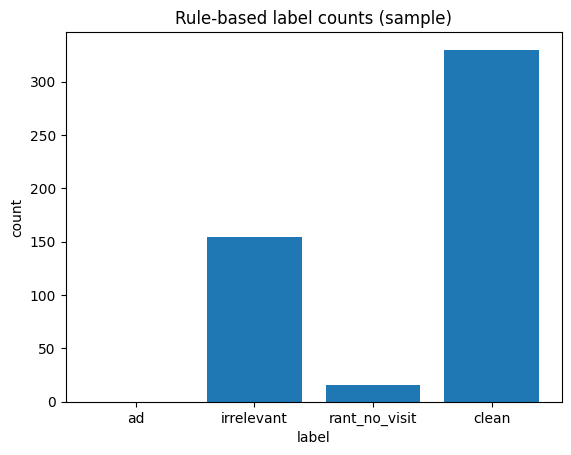

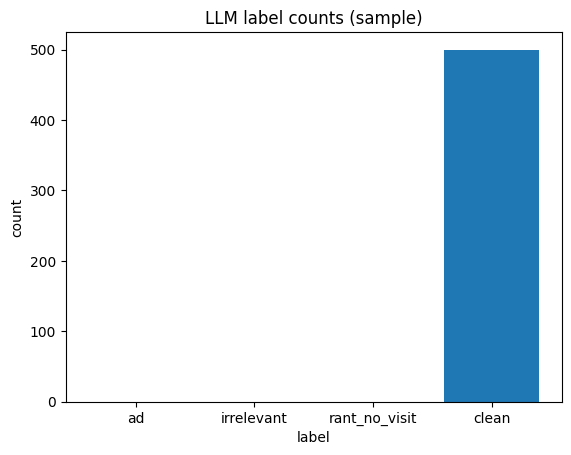

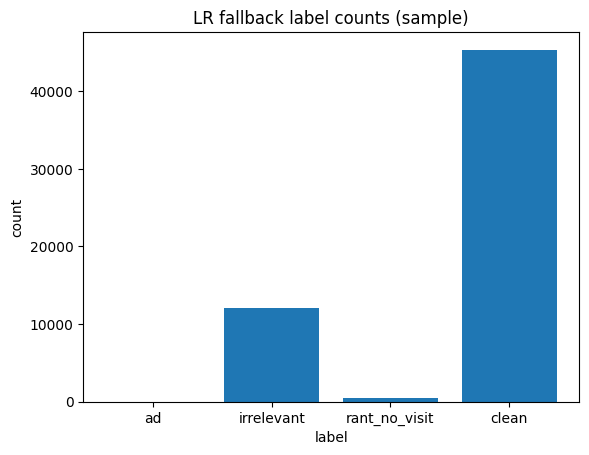

In [49]:
# 📈 Cell 11 — Simple label count bar charts (rule vs LLM vs LR)

def plot_counts(title: str, counts: Dict[str, int]):
    plt.figure()
    plt.bar(list(counts.keys()), list(counts.values()))   # no explicit colors
    plt.title(title)
    plt.xlabel("label")
    plt.ylabel("count")
    plt.show()

rule_counts = {c: int(y_sample[c].sum()) for c in CATEGORIES}
plot_counts("Rule-based label counts (sample)", rule_counts)

if not df_llm.empty:
    llm_counts = {c: int(df_llm[c].sum()) for c in CATEGORIES}
    plot_counts("LLM label counts (sample)", llm_counts)

lr_counts = {c: int(y_lr[c].sum()) for c in CATEGORIES}
plot_counts("LR fallback label counts (sample)", lr_counts)


In [46]:
# 📊 Cell — Confusion Matrices for each category
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_conf_matrix(y_true, y_pred, labels, title_prefix=""):
    for c in labels:
        cm = confusion_matrix(y_true[c], y_pred[c])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
        disp.plot(cmap="Blues", values_format="d")
        plt.title(f"{title_prefix} {c}")
        plt.show()


# Rule vs LR
plot_conf_matrix(y_sample, y_lr, CATEGORIES, title_prefix="LR vs rule")


ValueError: Found input variables with inconsistent numbers of samples: [500, 58289]